# Generate a ML estimated agb map with  lidar, L and PBand

This notebook uses machine learning for generating a machine learning estimated above ground biomass map of the Lope National Forest, Gabon, by using as a training set the data collected from the joint NASA-ESA AfriSAR campaign. Specifically, we use NASA LBand and ESA PBand radar backscatters, and NASA LVIS lidar data. We use field data as ground truth for training the machine. The algorithm we used is the scikit-learn implementation of Random Forest, and we optimized the hyperparameters to achieve the best results with unknown data.

_time < 2m_

_Input: LBand and PBand rasters 40m from N2, LVIS raster 40m from N5, AGB vector from N1, LBand and PBand vectors from N3, LVIS vector from N6, wcm model and map from N1, ML model and map from N4_

## 1. Import modules

In [2]:
import plant
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os import path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import r2_score
from joblib import dump, load

%matplotlib inline

## 2. Global variables

In [3]:
from config import *

In [4]:
training_LHH = plant.read_image(training_LHH_file).image
training_LHV = plant.read_image(training_LHV_file).image
training_LVV = plant.read_image(training_LVV_file).image
training_PHV = plant.read_image(training_PHV_file).image
training_lvis = plant.read_image(training_lvis_file).image

training_agb = plant.read_image(training_agb_file).image

opening: /home/croce/ml/dat/lband/rtc/output/n4/LHH_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/n4/LHV_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/n4/LVV_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/pband/output/n4/PHV_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lvis/output/zt_m_zg_20_vect.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/field/output/agb_vect.tiff (GDAL: GTiff) 


In [5]:
training_df = pd.DataFrame({'LHH': training_LHH.flatten(), 
                            'LHV': training_LHV.flatten(),
                            'LVV': training_LVV.flatten(),
                            'PHV': training_PHV.flatten(),
                            'lvis': training_lvis.flatten(),
                            'agb': training_agb.flatten()
                           })

## 3. Analyze the training set and remove NaN and 0 values

We experienced better results by converting the radar backascatters in dB. We therefore decided to filter out all the NaN and the 0 values from the training set.

In [6]:
print('Training Set:')
print(training_df.shape)
training_df.head()
print('')
print('Number of NaN values:')
print(np.isnan(training_df).sum())
print('')
print('Number of 0 values:')
print((training_df == 0).sum())

Training Set:
(192, 6)

Number of NaN values:
LHH     24
LHV     24
LVV     24
PHV     40
lvis    24
agb     31
dtype: int64

Number of 0 values:
LHH     0
LHV     0
LVV     0
PHV     2
lvis    0
agb     0
dtype: int64


In [7]:
training_df.drop(training_df.loc[training_df['PHV']==0].index, inplace=True)

In [8]:
training_df.dropna(inplace=True)
training_df['LHV'] = 10*np.log10(training_df['LHV'])
training_df['LHH'] = 10*np.log10(training_df['LHH'])
training_df['LVV'] = 10*np.log10(training_df['LVV'])
training_df['PHV'] = 10*np.log10(training_df['PHV'])
training_df.describe()

LHH         LHV         LVV         PHV        lvis         agb
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000
mean    -8.741404  -15.206789   -9.497608  -16.684679   27.069860  186.964594
std      3.286808    5.051626    3.160932    5.762064   16.345758  151.468725
min    -17.212464  -26.989700  -16.197888  -30.000000    2.636000    0.018000
25%    -10.783836  -18.860566  -12.676062  -20.457575    8.336000    5.090000
50%     -7.212464  -12.291480   -7.904850  -13.872161   36.366000  221.785000
75%     -6.364043  -11.674911   -7.270003  -12.596373   39.797500  314.808500
max     -5.228787  -10.604807   -6.003263   -9.871628   48.506000  443.842000

In [9]:
X = training_df[[col for col in training_df.columns if col not in ['agb']]]
y = training_df['agb']

## 4. Train and evaluate the Random Forest Regressor

The Random Forest hyperparameters have been set to optimize the quality of the prediction of the model on unknown data.

In [10]:
ml_model = RandomForestRegressor(n_estimators=100,
                                 max_features='sqrt',
                                 min_samples_leaf=5,
                                 criterion='mae',
                                 bootstrap=True,
                                 oob_score=True,
                                 random_state=0)

In [11]:
scoring = {'neg_mean_absolute_error': 'neg_mean_absolute_error'}
scores = cross_validate(ml_model, X, y, 
                        scoring=scoring, 
                        cv=10, 
                        return_train_score=True,
                        return_estimator=True,
                        n_jobs=-1)

In [12]:
print('Negative Mean Absolute Error:')
print('TRAIN:', scores['train_neg_mean_absolute_error'].mean())
print('TEST:', scores['test_neg_mean_absolute_error'].mean())

Negative Mean Absolute Error:
TRAIN: -28.37284070052084
TEST: -39.68896927142856


In [13]:
trained_model = ml_model.fit(X, y)
print(trained_model)
print()
print('Out-of-bag score (R^2):', trained_model.oob_score_)
_ = dump(trained_model, model_file_lplid) 

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=0, verbose=0,
                      warm_start=False)

Out-of-bag score (R^2): 0.8508785915630457


Feature ranking:
1. feature lvis (0.402498)
2. feature LVV (0.292339)
3. feature LHV (0.180483)
4. feature PHV (0.083461)
5. feature LHH (0.041218)


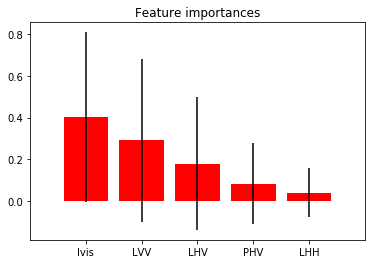

In [14]:
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

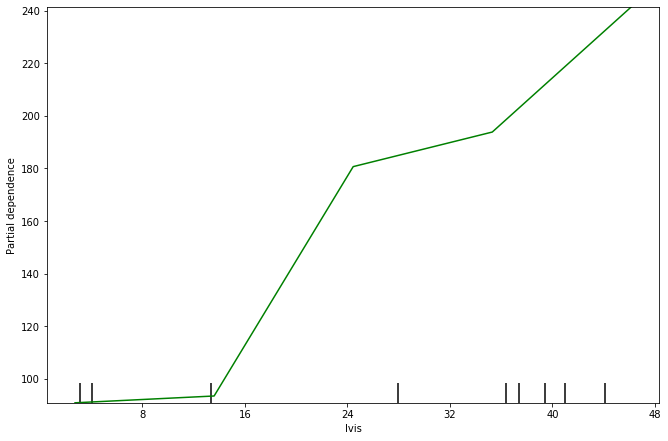

In [15]:
fig = plt.figure(figsize=(10,10))
plot_partial_dependence(trained_model, X,
                        features=[4],
                        feature_names=X.columns,
                        fig=fig,
                        grid_resolution=5)


## 5. Generate and visualize the estimated agb map

The data we use for generating the estimated map has to be consistent with the training set we used for building the model.

In [16]:
LHH = plant.read_image(LHH_file).image
LHV = plant.read_image(LHV_file).image
LVV = plant.read_image(LVV_file).image
PHV = plant.read_image(PHV_file).image
lvis = plant.read_image(lvis_file_40).image

opening: /home/croce/ml/dat/lband/rtc/output/LHH_colo_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/LHV_colo_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/output/LVV_colo_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/pband/output/warped_afrisar_dlr_T2-0_SLC_HV_geocoded_40.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lvis/output/lvis_colo_40.tiff (GDAL: GTiff) 


In [17]:
LHH_pd = pd.DataFrame(LHH)
LHV_pd = pd.DataFrame(LHV)
LVV_pd = pd.DataFrame(LVV)
PHV_pd = pd.DataFrame(PHV)
lvis_pd = pd.DataFrame(lvis)

In [18]:
predict_df = pd.DataFrame({'LHH': LHH_pd.values.flatten(),
                           'LHV': LHV_pd.values.flatten(),
                           'LVV': LVV_pd.values.flatten(),
                           'PHV': PHV_pd.values.flatten(),
                           'lvis': lvis_pd.values.flatten(),
                          })

In [19]:
print('Target Set:')
print(predict_df.shape)
print('')
print('NaN:')
print(np.isnan(predict_df).sum())
print('')
print('Number of 0 values:')
print((training_df == 0).sum())

Target Set:
(81760, 5)

NaN:
LHH      4909
LHV      4909
LVV      4909
PHV     43915
lvis     6943
dtype: int64

Number of 0 values:
LHH     0
LHV     0
LVV     0
PHV     0
lvis    0
agb     0
dtype: int64


In [20]:
warnings.filterwarnings('ignore')

predict_df['LHV'] = 10*np.log10(predict_df['LHV'])
predict_df['LHH'] = 10*np.log10(predict_df['LHH'])
predict_df['LVV'] = 10*np.log10(predict_df['LVV'])
predict_df['PHV'] = 10*np.log10(predict_df['PHV'])

to_pred = predict_df.dropna()
to_pred.describe()

LHH           LHV           LVV           PHV          lvis
count  37843.000000  37843.000000  37843.000000  37843.000000  37843.000000
mean      -7.903460    -13.857117     -8.222896    -16.200171     30.877678
std        3.117103      4.274616      2.782082      5.853504     16.074005
min      -21.001576    -30.942765    -18.954963    -40.661949      2.524325
25%       -8.557242    -14.404065     -9.202491    -17.722526     15.367060
50%       -6.729721    -12.045915     -7.209928    -13.928749     38.276241
75%       -5.914586    -11.164833     -6.338046    -12.475166     43.265701
max        5.860499      0.619370      5.569906     -0.939174     59.930054

In [21]:
predictions = trained_model.predict(to_pred)

In [22]:
to_pred.insert(5, 'est_agb', predictions)
joined_df = predict_df.join(to_pred['est_agb'])

In [23]:
joined_df.describe()

LHH           LHV           LVV           PHV          lvis  \
count  76848.000000  76850.000000  76848.000000  37845.000000  74817.000000   
mean      -7.677877    -13.455654     -7.919625    -16.200457     33.629177   
std        3.006164      3.999880      2.679672      5.853615     15.228373   
min      -32.307969    -38.838865    -20.627252    -40.661949      2.524325   
25%       -8.150992    -13.588360     -8.616616    -17.722723     27.132004   
50%       -6.656773    -11.923823     -7.069802    -13.928770     40.016079   
75%       -5.839434    -11.062832     -6.188080    -12.475181     44.261082   
max        6.904562      0.619370      6.352816     -0.939174     65.700012   

            est_agb  
count  37843.000000  
mean     205.381980  
std      124.320729  
min        0.079645  
25%       55.508777  
50%      267.718015  
75%      307.169723  
max      356.833425

In [24]:
array_image = joined_df['est_agb'].values.reshape(LHH.shape)
image_obj = plant.read_image(file_LHH)
image_obj.set_image(array_image, band=0)
plant.save_image(image_obj,
                 output_file=lplid_map_file,
                 force=True)

saving band 0: MEM:140609954661072
## file saved: /home/croce/ml/dat/products/map_lvisLPbands_192tr.tiff (GDAL:GTiff)


## output file(s):
##     /home/croce/ml/dat/products/map_lvisLPbands_192tr.tiff


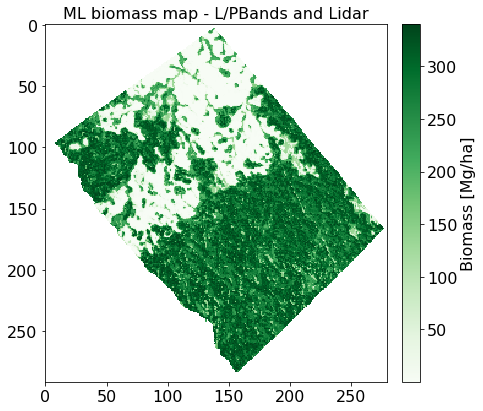

In [25]:
_ = plant.display(lplid_map_file, 
                  cmap='Greens',
                  background_color='white',
                  title='ML biomass map - L/PBands and Lidar',
                  colorbar_label='Biomass [Mg/ha]',
                  **options)

opening: /home/croce/ml/dat/products/map_Lmodel.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/products/map_LPbands_192tr_rtc.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/products/map_lvisLPbands_192tr.tiff (GDAL: GTiff) 
opening: /home/croce/ml/dat/lband/rtc/coeffs/coeffs_wcm.bin (GDAL: ENVI) 


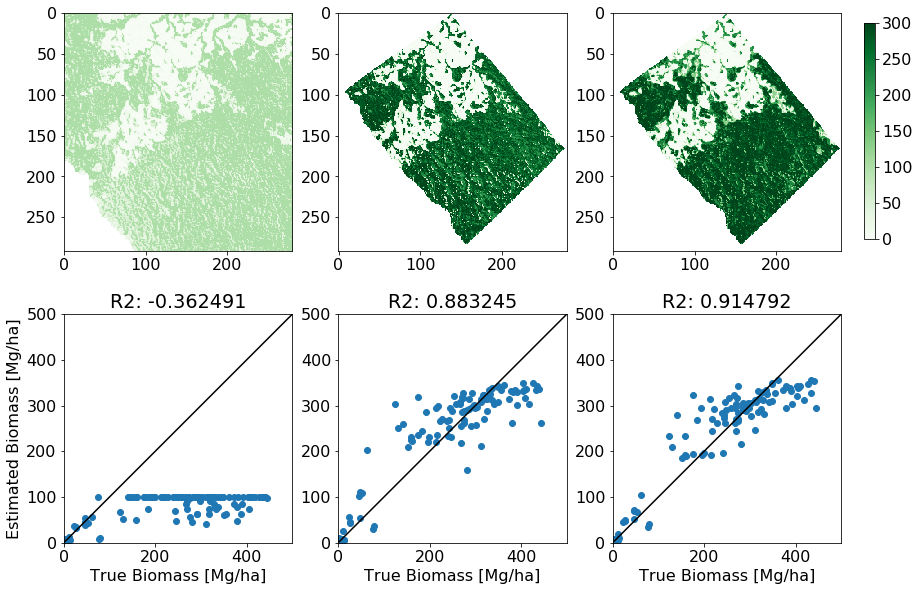

In [26]:
wcm_map = plant.read_image(wcm_map_file).image
lp_map = plant.read_image(lp_map_file).image
lplid_map = plant.read_image(lplid_map_file).image

coeffs_lband = plant.read_image(coeffs_file)
coeffs_lband_hv = coeffs_lband.image[0, :]
coeffs_lband_hv_str = ' '.join([str(c) for c in coeffs_lband_hv])
backscatter_100Mg = plant.util(100, evaluate='wcm_db '+coeffs_lband_hv_str, **options).image[0][0]

# Generating est_agb_wcm
training_LHV_clipped = plant.util(training_LHV_file,
                                  db=True,
                                  clip=[np.nan, backscatter_100Mg], 
                                  **options).image
est_agb_wcm = plant.util(training_LHV_clipped,
                         evaluate='wcm_db_inv '+coeffs_lband_hv_str, 
                         **options).image
r2_df = pd.DataFrame({'true': training_agb.flatten(),
                      'pred': est_agb_wcm.flatten()})
r2_df.dropna(inplace=True),
det_score_wcm = r2_score(r2_df['true'], r2_df['pred'])

# Generating L/PBands agb
predict_df = pd.DataFrame({'LHH': training_LHH.flatten(),
                           'LHV': training_LHV.flatten(),
                           'LVV': training_LVV.flatten(),
                           'PHV': training_PHV.flatten(),
                          })
no0_pred = predict_df.drop(predict_df.loc[predict_df['PHV']==0].index)
no0_pred['LHV'] = 10*np.log10(no0_pred['LHV'])
no0_pred['LHH'] = 10*np.log10(no0_pred['LHH'])
no0_pred['LVV'] = 10*np.log10(no0_pred['LVV'])
no0_pred['PHV'] = 10*np.log10(no0_pred['PHV'])

to_pred = no0_pred.dropna()
pred_agb = load(model_file_lp).predict(to_pred)
to_pred.insert(4, 'est_agb', pred_agb)
joined_df = predict_df.join(to_pred['est_agb'])
est_agb_lp = joined_df['est_agb']
r2_df = pd.DataFrame({'true': training_agb.flatten(),
                      'pred': est_agb_lp})
r2_df.dropna(inplace=True),
det_score_lp = r2_score(r2_df['true'], r2_df['pred'])

# Generating L/PBands + lidar agb
predict_df = pd.DataFrame({'LHH': training_LHH.flatten(),
                           'LHV': training_LHV.flatten(),
                           'LVV': training_LVV.flatten(),
                           'PHV': training_PHV.flatten(),
                           'lvis': training_lvis.flatten()
                          })
no0_pred = predict_df.drop(predict_df.loc[predict_df['PHV']==0].index)
no0_pred['LHV'] = 10*np.log10(no0_pred['LHV'])
no0_pred['LHH'] = 10*np.log10(no0_pred['LHH'])
no0_pred['LVV'] = 10*np.log10(no0_pred['LVV'])
no0_pred['PHV'] = 10*np.log10(no0_pred['PHV'])

to_pred = no0_pred.dropna()
pred_agb = trained_model.predict(to_pred)
to_pred.insert(5, 'est_agb', pred_agb)
joined_df = predict_df.join(to_pred['est_agb'])
est_agb_lplid = joined_df['est_agb']
r2_df = pd.DataFrame({'true': training_agb.flatten(),
                      'pred': est_agb_lplid})
r2_df.dropna(inplace=True),
det_score_lplid = r2_score(r2_df['true'], r2_df['pred'])

# Plots
vmin_cbar = 0
vmax_cbar = 300
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.set_size_inches((16,10))
cbar_ax = fig.add_axes([0.65, 0.56, 0.20, 0.30])
cbar_ax.set_visible(False)
fig.subplots_adjust(right=0.8)

im = ax1.imshow(wcm_map, cmap='Greens', vmin=vmin_cbar, vmax=vmax_cbar)
ax4.scatter(training_agb.flatten(), est_agb_wcm.flatten())
ax4.set_xlim(0,500)
ax4.set_ylim(ax4.get_xlim())
ax4.set_title("R2: {0:f}".format(det_score_wcm), fontsize='large')
ax4.set_xlabel("True Biomass [Mg/ha]")
ax4.set_ylabel("Estimated Biomass [Mg/ha]")
x = np.linspace(*ax4.get_xlim())
ax4.plot(x, x, color='black')
ax4.set_aspect('equal', adjustable='box')

im = ax2.imshow(lp_map, cmap='Greens', vmin=vmin_cbar, vmax=vmax_cbar)
ax5.scatter(training_agb.flatten(), est_agb_lp)
ax5.set_xlim(0,500)
ax5.set_ylim(ax5.get_xlim())
ax5.set_title("R2: {0:f}".format(det_score_lp), fontsize='large')
ax5.set_xlabel("True Biomass [Mg/ha]")
x = np.linspace(*ax5.get_xlim())
ax5.plot(x, x, color='black')
ax5.set_aspect('equal', adjustable='box')

im = ax3.imshow(lplid_map, cmap='Greens', vmin=vmin_cbar, vmax=vmax_cbar)
fig.colorbar(im, ax=cbar_ax, orientation='vertical')
ax6.scatter(training_agb.flatten(), est_agb_lplid)
ax6.set_xlim(0,500)
ax6.set_ylim(ax6.get_xlim())
ax6.set_title("R2: {0:f}".format(det_score_lplid), fontsize='large')
ax6.set_xlabel("True Biomass [Mg/ha]")
x = np.linspace(*ax6.get_xlim())
ax6.plot(x, x, color='black')
ax6.set_aspect('equal', adjustable='box')

_Note: R2 has been calculated using the training set. A proper calculation would involve an independent set._

Share the results with the MAAP: ML model and agb map